# Awkward *Quick, Draw!* GAN with No Warning

In this notebook, we use an awkward workaround to avoid the unnecessary Keras warning produced by our [*Quick, Draw!* GAN](https://github.com/the-deep-learners/deep-learning-illustrated/blob/master/notebooks/generative_adversarial_network.ipynb).

_In order to efficiently carry out the training in this notebook, we recommend using a GPU. Most readers don't have a GPU suitable for TensorFlow operations (i.e., an Nvidia GPU with CUDA and cuDNN drivers installed) available on their local machine, however you can easily access one for free via [Colab](https://colab.research.google.com/)._ 

_Separately, for reasons that escape us, the discriminator in this notebook nearly always fails to learn if you train on a CPU only. Because of this failure, the GAN will seldom learn how to generate sketches -- i.e., it will output images that are merely random noise. There are two ways we've identified to remedy this situation:_ 

1. _**Use a GPU.** If you don't have one, use Colab as suggested above. While in Colab, you can select "Change runtime type" from the "Runtime" item in the menu bar, and choose "GPU" as your hardware accelerator. This hardware accelerator trains the GAN orders of magnitude more rapidly than the "None" or "TPU" options, and the discriminator (we have no idea why!) will train properly._
2. _**Change the discriminator's optimizer.** As noted by a comment in this notebook's discriminator compilation step, switching from the default RMSprop optimizer to another (e.g., Adam or AdaDelta) enables the discriminator to learn effectively and therefore the GAN generates sketches. Whether you use a CPU only, a GPU, or a TPU, this solution is effective. (That said, training the GAN with a GPU is still way faster than with a CPU only or a TPU.)_

#### Load dependencies

In [1]:
%pip install -r /workspace/requirements.txt

     |████████████████████████████████| 107 kB 7.0 MB/s eta 0:00:01
     |████████████████████████████████| 312 kB 14.1 MB/s eta 0:00:01
     |████████████████████████████████| 1.5 MB 10.8 MB/s eta 0:00:01
     |████████████████████████████████| 24.0 MB 18.3 MB/s eta 0:00:01     |████████████████▉               | 12.6 MB 10.9 MB/s eta 0:00:02     |███████████████████▍            | 14.6 MB 10.9 MB/s eta 0:00:01
     |████████████████████████████████| 721 kB 14.4 MB/s eta 0:00:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 771 kB 18.2 MB/s eta 0:00:01
     |████████████████████████████████| 96 kB 4.9 MB/s  eta 0:00:01
     |████████████████████████████████| 78 kB 5.5 MB/s  eta 0:00:01
     |████████████████████████████████| 56 kB 4.2 MB/s  eta 0:00:01
     |████████████████████████████████| 67 kB 4.5 MB/s  eta 0:00:01
  Created wheel for tflearn: filename=tflearn-0.5.

In [2]:
# for data input and output:
import numpy as np
import os

# for deep learning: 
import keras
from keras.models import Model
from keras.layers import Input, Dense, Conv2D, Dropout, Lambda
from keras.layers import BatchNormalization, Flatten
from keras.layers import Activation
from keras.layers import Reshape # new! 
from keras.layers import Conv2DTranspose, UpSampling2D # new! 
from keras.optimizers import RMSprop # new!
from keras import backend as K

# for plotting: 
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline

Using TensorFlow backend.
2023-01-26 13:40:22.771797: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0


#### Load data
NumPy bitmap files are [here](https://console.cloud.google.com/storage/browser/quickdraw_dataset/full/numpy_bitmap) -- pick your own drawing category -- you don't have to pick *apples* :)

In [6]:
input_images = "/workspace/quickdraw_data/apple.npy"

In [7]:
data = np.load(input_images) # 28x28 (sound familiar?) grayscale bitmap in numpy .npy format; images are centered

In [8]:
data.shape

(144722, 784)

In [5]:
# data[4242]

In [9]:
data = data/255
data = np.reshape(data,(data.shape[0],28,28,1)) # fourth dimension is color
img_w,img_h = data.shape[1:3]
# data.shape

In [7]:
# data[4242]

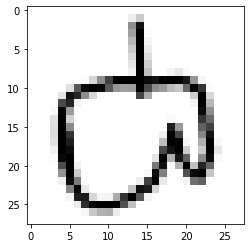

In [10]:
plt.imshow(data[4242,:,:,0], cmap='Greys')

#### Create discriminator network

In [11]:
def build_discriminator(depth=64, p=0.4):

    # Define inputs
    image = Input((img_w,img_h,1))
    
    # Convolutional layers
    conv1 = Conv2D(depth*1, 5, strides=2, 
                   padding='same', activation='relu')(image)
    conv1 = Dropout(p)(conv1)
    
    conv2 = Conv2D(depth*2, 5, strides=2, 
                   padding='same', activation='relu')(conv1)
    conv2 = Dropout(p)(conv2)
    
    conv3 = Conv2D(depth*4, 5, strides=2, 
                   padding='same', activation='relu')(conv2)
    conv3 = Dropout(p)(conv3)
    
    conv4 = Conv2D(depth*8, 5, strides=1, 
                   padding='same', activation='relu')(conv3)
    conv4 = Flatten()(Dropout(p)(conv4))
    
    # Output layer
    prediction = Dense(1, activation='sigmoid', name='prediction')(conv4)
    
    # Model definition
    model = Model(inputs=image, outputs=prediction)
    
    return model

In [12]:
discriminator = build_discriminator()

In [13]:
discriminator.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 64)        1664      
_________________________________________________________________
dropout_1 (Dropout)          (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 7, 7, 128)         204928    
_________________________________________________________________
dropout_2 (Dropout)          (None, 7, 7, 128)         0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 4, 4, 256)         819456    
_________________________________________________________________
dropout_3 (Dropout)          (None, 4, 4, 256)         0         
__________

In [14]:
discriminator.compile(loss='binary_crossentropy', 
                      optimizer=RMSprop(lr=0.0008,
                                        decay=6e-8,
                                        clipvalue=1.0),
                      metrics=['binary_accuracy'])

#### Build an untrainable discriminator

To create a workaround that avoids the following (unnecessary!) warning being thrown by recent versions of Keras...

`Discrepancy between trainable weights and collected trainable weights, did you set model.trainable without calling model.compile after ?`

...we awkwardly build a second, discriminator (`discriminator_`) for use in the adversarial model. This model is identical to the first discriminator (`discriminator`) except that it's unequivocally _untrainable_ (it isn't even compiled!). We copy the weights from the trainable `discriminator` model into the untrainable `discriminator_` model each time we want to use it. Thus, the adversarial model gets a fresh _copy_ of the discriminator's parameters in each round of training.

In [15]:
# Build an identical discriminator: 
discriminator_ = build_discriminator()

# Set the model so that its parameters are frozen: 
discriminator_.trainable = False

In [16]:
# Function to copy the weights from the trainable discriminator to the frozen discriminator_
def copy_weights(source, target):
    for i, layer in enumerate(source.layers):
        target.layers[i].set_weights(source.layers[i].get_weights())

#### Create generator network

In [17]:
z_dimensions = 32

In [19]:
def build_generator(latent_dim=z_dimensions, 
                    depth=64, p=0.4):
    
    # Define inputs
    noise = Input((latent_dim,))
    
    # First dense layer
    dense1 = Dense(7*7*depth)(noise)
    dense1 = BatchNormalization(momentum=0.9)(dense1) # default momentum for moving average is 0.99
    dense1 = Activation(activation='relu')(dense1)
    dense1 = Reshape((7,7,depth))(dense1)
    dense1 = Dropout(p)(dense1)
    
    # De-Convolutional layers
    conv1 = UpSampling2D()(dense1)
    conv1 = Conv2DTranspose(int(depth/2), 
                            kernel_size=5, padding='same', 
                            activation=None,)(conv1)
    conv1 = BatchNormalization(momentum=0.9)(conv1)
    conv1 = Activation(activation='relu')(conv1)
    
    conv2 = UpSampling2D()(conv1)
    conv2 = Conv2DTranspose(int(depth/4), 
                            kernel_size=5, padding='same', 
                            activation=None,)(conv2)
    conv2 = BatchNormalization(momentum=0.9)(conv2)
    conv2 = Activation(activation='relu')(conv2)
    
    conv3 = Conv2DTranspose(int(depth/8), 
                            kernel_size=5, padding='same', 
                            activation=None,)(conv2)
    conv3 = BatchNormalization(momentum=0.9)(conv3)
    conv3 = Activation(activation='relu')(conv3)

    # Output layer
    image = Conv2D(1, kernel_size=5, padding='same', 
                   activation='sigmoid')(conv3)

    # Model definition    
    model = Model(inputs=noise, outputs=image)
    
    return model

In [20]:
generator = build_generator()

2023-01-26 13:49:12.984612: I tensorflow/core/platform/profile_utils/cpu_utils.cc:109] CPU Frequency: 31250000 Hz
2023-01-26 13:49:12.987035: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x23e38b50 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2023-01-26 13:49:12.987216: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version
2023-01-26 13:49:13.016671: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2023-01-26 13:49:13.224302: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:1049] ARM64 does not support NUMA - returning NUMA node zero
2023-01-26 13:49:13.225180: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x257b7f30 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-01-26 13:49:13.225323: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor

2023-01-26 13:49:16.285791: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1206] Device interconnect StreamExecutor with strength 1 edge matrix:
2023-01-26 13:49:16.286002: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1212]      0 
2023-01-26 13:49:16.286086: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1225] 0:   N 
2023-01-26 13:49:16.287940: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:1049] ARM64 does not support NUMA - returning NUMA node zero
2023-01-26 13:49:16.288569: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:1049] ARM64 does not support NUMA - returning NUMA node zero
2023-01-26 13:49:16.288918: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1351] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 1731 MB memory) -> physical GPU (device: 0, name: Xavier, pci bus id: 0000:00:00.0, compute capability: 7.2)


In [17]:
# generator.compile(loss='binary_crossentropy', 
#                           optimizer=RMSprop(lr=0.0004, 
#                                             decay=3e-8, 
#                                             clipvalue=1.0), 
#                           metrics=['accuracy'])

In [18]:
# generator.summary()

#### Create adversarial network

In [21]:
def build_adversarial():
          
    # Define input
    z = Input(shape=(z_dimensions,))
    
    # Generate image from noise
    img = generator(z)
    
    # Make prediction
    pred = discriminator_(img)
       
    # Build model
    model = Model(inputs=z, outputs=pred)
    
    return model

In [22]:
adversarial_model = build_adversarial()

In [24]:
# adversarial_model.summary()

In [23]:
adversarial_model.compile(loss='binary_crossentropy', 
                          optimizer=RMSprop(lr=0.0004, 
                                            decay=3e-8, 
                                            clipvalue=1.0), 
                          metrics=['accuracy'])

#### Train!

In [24]:
def train(epochs=2000, batch=128, z_dim=z_dimensions):
    
    d_metrics = []
    a_metrics = []
    
    running_d_loss = 0
    running_d_acc = 0
    running_a_loss = 0
    running_a_acc = 0
    
    for i in range(epochs):
        
        #######################
        # train discriminator:#
        #######################
        
        # sample real images: 
        real_imgs = np.reshape(
            data[np.random.choice(data.shape[0],
                                  batch,
                                  replace=False)],
            (batch,28,28,1))
        
        # generate fake images: 
        fake_imgs = generator.predict(
            np.random.uniform(-1.0, 1.0, 
                              size=[batch, z_dim]))
        
        # concatenate images as discriminator inputs:
        x = np.concatenate((real_imgs,fake_imgs))
        
        # assign y labels for discriminator:
        # Added noisy labels, as per here: https://link.medium.com/yUuw4Y33PX
        # Note: disciminator accuracy will always be zero now...
        y = np.ones([2*batch,1]) - np.random.uniform(0,0.1,[2*batch,1])
        y[batch:,:] = 0
        y[batch:,:] += np.random.uniform(0,0.1,[batch,1])
        
        # do training
        d_metrics.append(
            discriminator.train_on_batch(x,y)
        )
        running_d_loss += d_metrics[-1][0]
        running_d_acc += d_metrics[-1][1]
        
        #########################
        # train adversarial net:#
        #########################
        
        # adversarial net's noise input and "real" y: 
        noise = np.random.uniform(-1.0, 1.0, 
                                  size=[batch, z_dim])
        y = np.ones([batch,1])
        
        # Copy weights to frozen discriminator
        copy_weights(discriminator, discriminator_)
        
        # do training
        a_metrics.append(
            adversarial_model.train_on_batch(noise,y)
        ) 
        running_a_loss += a_metrics[-1][0]
        running_a_acc += a_metrics[-1][1]
        
        #########################
        #     Print results     #
        #########################
        
        # periodically print progress & fake images: 
        if (i+1)%20 == 0:

            print('Epoch #{}'.format(i))
            log_mesg = "%d: [D loss: %f, acc: %f]" % \
            (i, running_d_loss/i, running_d_acc/i)
            log_mesg = "%s  [A loss: %f, acc: %f]" % \
            (log_mesg, running_a_loss/i, running_a_acc/i)
            print(log_mesg)

            noise = np.random.uniform(-1.0, 1.0, 
                                      size=[16, z_dim])
            gen_imgs = generator.predict(noise)

            plt.figure(figsize=(5,5))

            for k in range(gen_imgs.shape[0]):
                plt.subplot(4, 4, k+1)
                plt.imshow(gen_imgs[k, :, :, 0], 
                           cmap='gray')
                plt.axis('off')
                
            plt.tight_layout()
            plt.show()
    
    return a_metrics, d_metrics

2023-01-26 13:50:39.580978: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.11
2023-01-26 13:50:43.342306: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudnn.so.8




Epoch #19
19: [D loss: 0.556899, acc: 0.000000]  [A loss: 1.146041, acc: 0.490132]


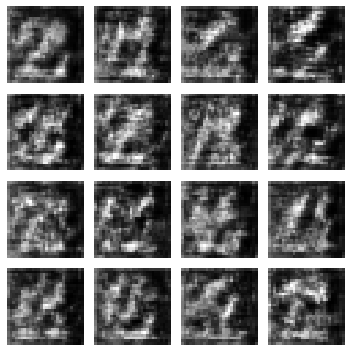

Epoch #39
39: [D loss: 0.399849, acc: 0.000000]  [A loss: 1.806827, acc: 0.273838]


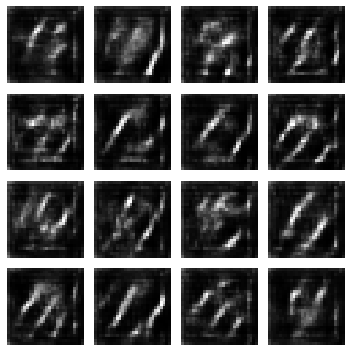

Epoch #59
59: [D loss: 0.369662, acc: 0.000000]  [A loss: 2.037818, acc: 0.208422]


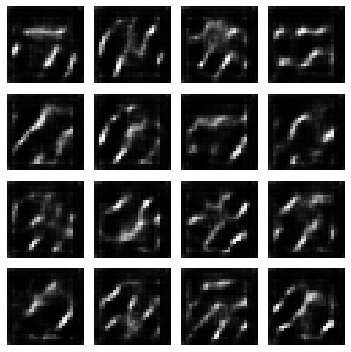

Epoch #79
79: [D loss: 0.352087, acc: 0.000000]  [A loss: 2.258491, acc: 0.168513]


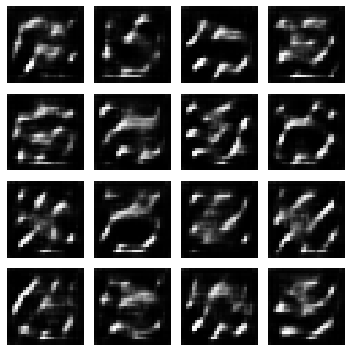

Epoch #99
99: [D loss: 0.338204, acc: 0.000000]  [A loss: 2.414274, acc: 0.143860]


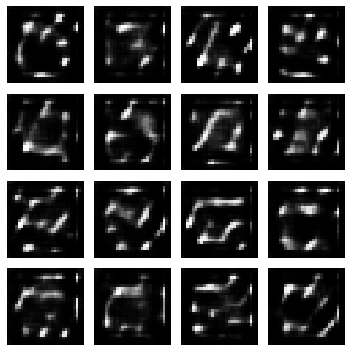

Epoch #119
119: [D loss: 0.332331, acc: 0.000000]  [A loss: 2.500653, acc: 0.124934]


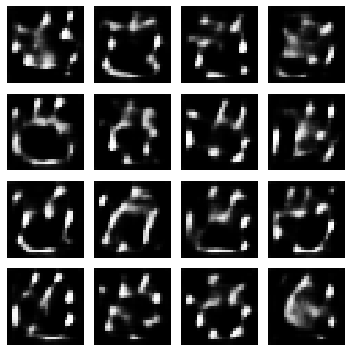

Epoch #139
139: [D loss: 0.337164, acc: 0.000028]  [A loss: 2.524134, acc: 0.121571]


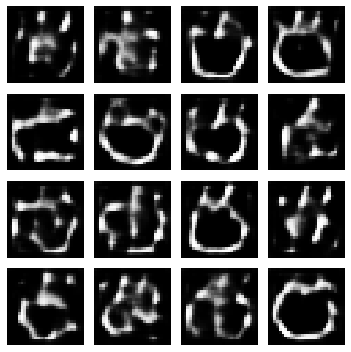

Epoch #159
159: [D loss: 0.342219, acc: 0.000025]  [A loss: 2.533310, acc: 0.119202]


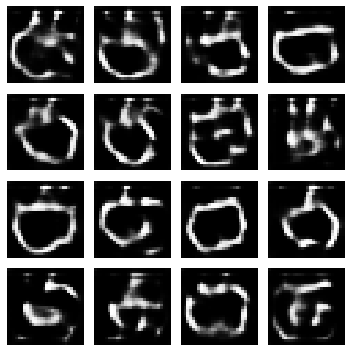

Epoch #179
179: [D loss: 0.354039, acc: 0.000022]  [A loss: 2.493851, acc: 0.114220]


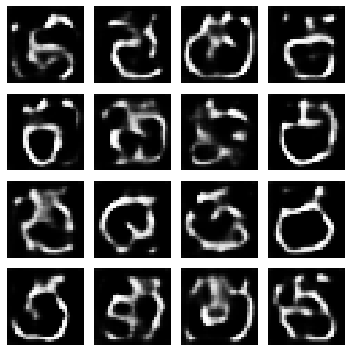

Epoch #199
199: [D loss: 0.359408, acc: 0.000020]  [A loss: 2.474723, acc: 0.116049]


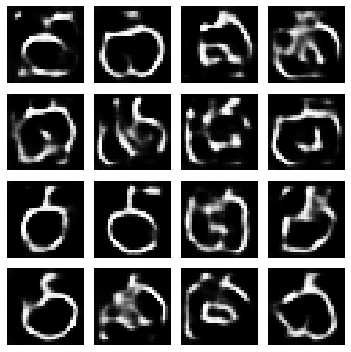

Epoch #219
219: [D loss: 0.366331, acc: 0.000018]  [A loss: 2.425626, acc: 0.125250]


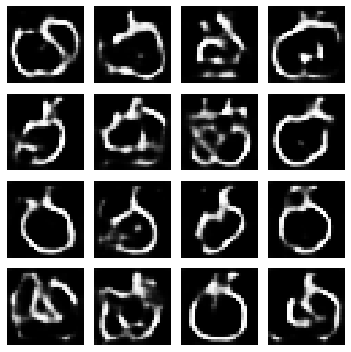

Epoch #239
239: [D loss: 0.375785, acc: 0.000016]  [A loss: 2.370032, acc: 0.128759]


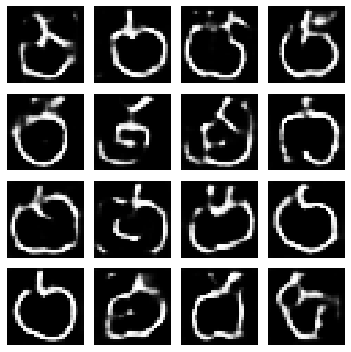

Epoch #259
259: [D loss: 0.383389, acc: 0.000015]  [A loss: 2.322440, acc: 0.129947]


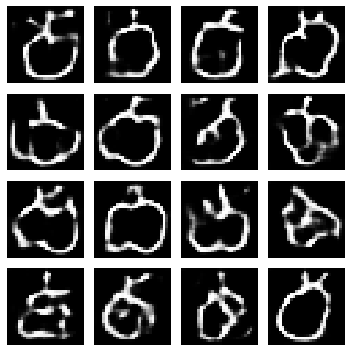

Epoch #279
279: [D loss: 0.390308, acc: 0.000014]  [A loss: 2.275678, acc: 0.131048]


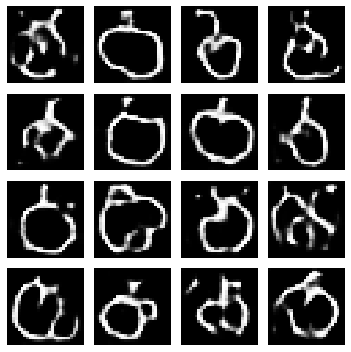

Epoch #299
299: [D loss: 0.397630, acc: 0.000013]  [A loss: 2.237006, acc: 0.132682]


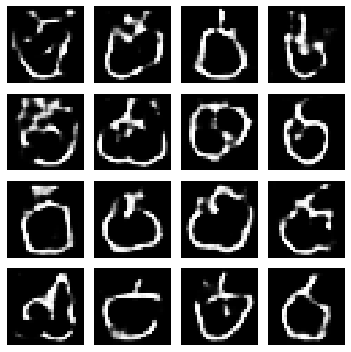

Epoch #319
319: [D loss: 0.404505, acc: 0.000012]  [A loss: 2.195761, acc: 0.135335]


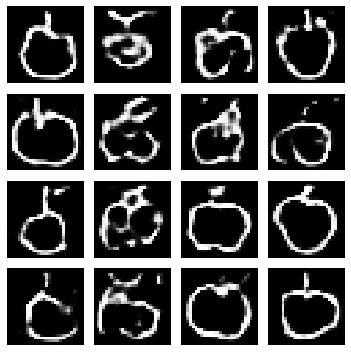

Epoch #339
339: [D loss: 0.410010, acc: 0.000012]  [A loss: 2.161670, acc: 0.134541]


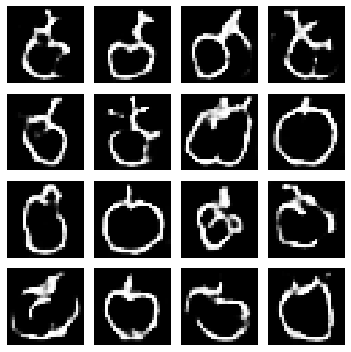

Epoch #359
359: [D loss: 0.416305, acc: 0.000011]  [A loss: 2.126918, acc: 0.136011]


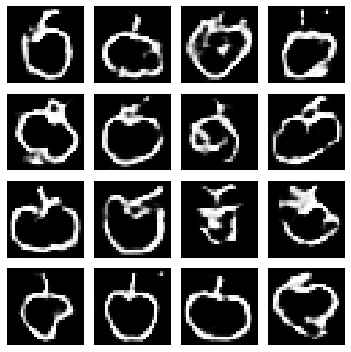

Epoch #379
379: [D loss: 0.421243, acc: 0.000010]  [A loss: 2.094632, acc: 0.137430]


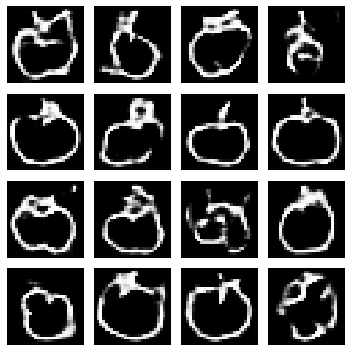

Epoch #399
399: [D loss: 0.425131, acc: 0.000010]  [A loss: 2.070256, acc: 0.137179]


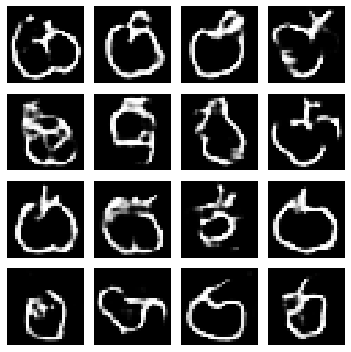

Epoch #419
419: [D loss: 0.428508, acc: 0.000009]  [A loss: 2.047041, acc: 0.136765]


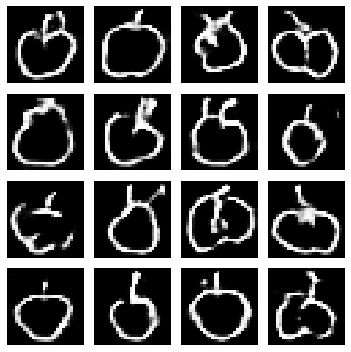

Epoch #439
439: [D loss: 0.430817, acc: 0.000009]  [A loss: 2.030627, acc: 0.136051]


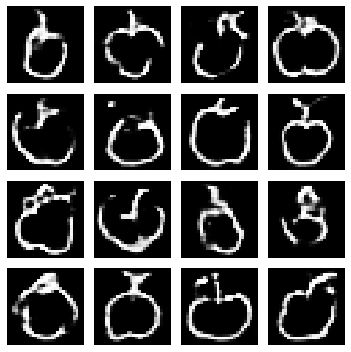

Epoch #459
459: [D loss: 0.433371, acc: 0.000009]  [A loss: 2.014344, acc: 0.136336]


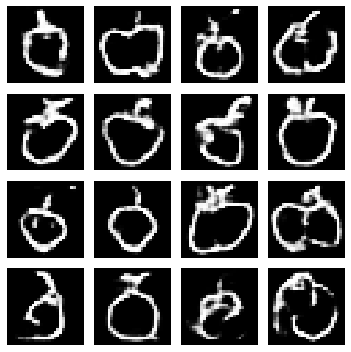

Epoch #479
479: [D loss: 0.435539, acc: 0.000008]  [A loss: 1.999796, acc: 0.135716]


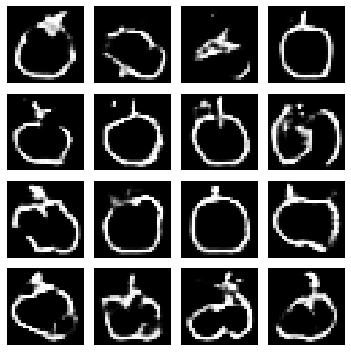

Epoch #499
499: [D loss: 0.436399, acc: 0.000008]  [A loss: 1.991925, acc: 0.134425]


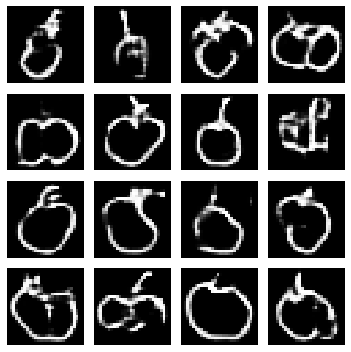

Epoch #519
519: [D loss: 0.437816, acc: 0.000008]  [A loss: 1.982436, acc: 0.133806]


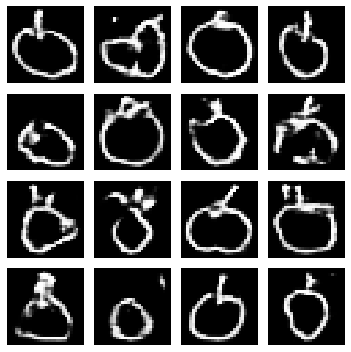

Epoch #539
539: [D loss: 0.438737, acc: 0.000007]  [A loss: 1.976279, acc: 0.133102]


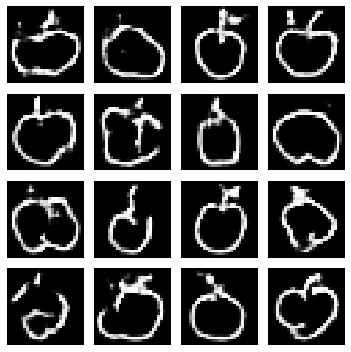

Epoch #559
559: [D loss: 0.439622, acc: 0.000007]  [A loss: 1.972380, acc: 0.132407]


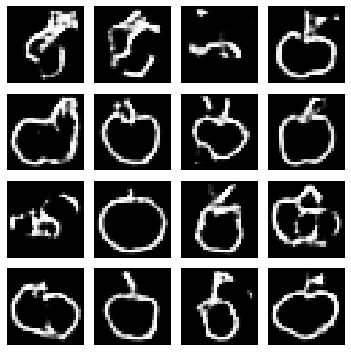

Epoch #579
579: [D loss: 0.440888, acc: 0.000007]  [A loss: 1.964568, acc: 0.131801]


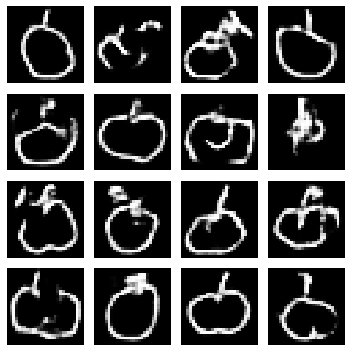

Epoch #599
599: [D loss: 0.441147, acc: 0.000007]  [A loss: 1.962492, acc: 0.131378]


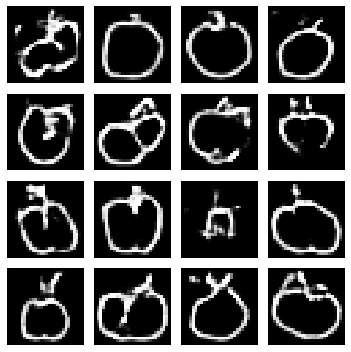

Epoch #619
619: [D loss: 0.442014, acc: 0.000006]  [A loss: 1.957693, acc: 0.130541]


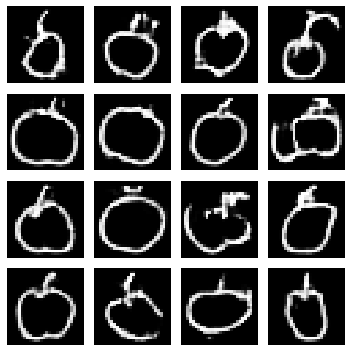

Epoch #639
639: [D loss: 0.442807, acc: 0.000006]  [A loss: 1.953602, acc: 0.129988]


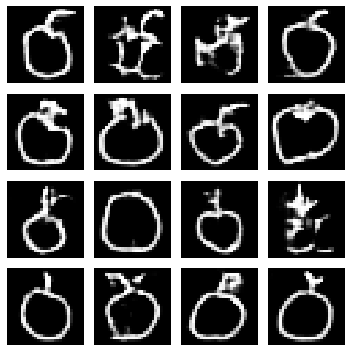

Epoch #659
659: [D loss: 0.443105, acc: 0.000006]  [A loss: 1.953530, acc: 0.129220]


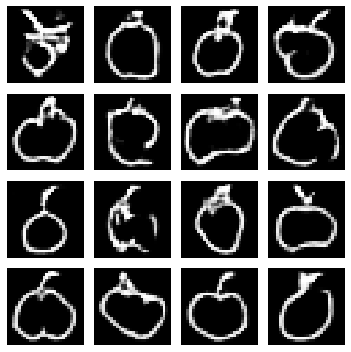

Epoch #679
679: [D loss: 0.443771, acc: 0.000006]  [A loss: 1.953152, acc: 0.128693]


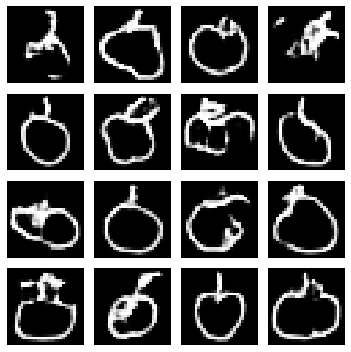

Epoch #699
699: [D loss: 0.443476, acc: 0.000006]  [A loss: 1.952737, acc: 0.128364]


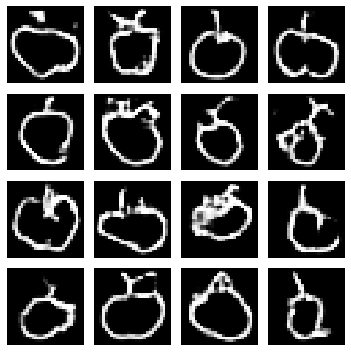

Epoch #719
719: [D loss: 0.444063, acc: 0.000005]  [A loss: 1.950252, acc: 0.128444]


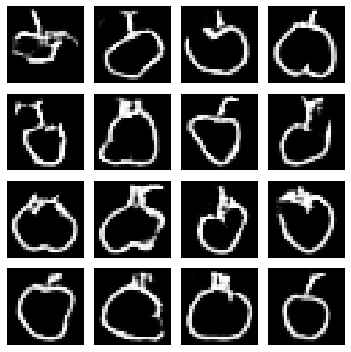

Epoch #739
739: [D loss: 0.444066, acc: 0.000005]  [A loss: 1.950892, acc: 0.128193]


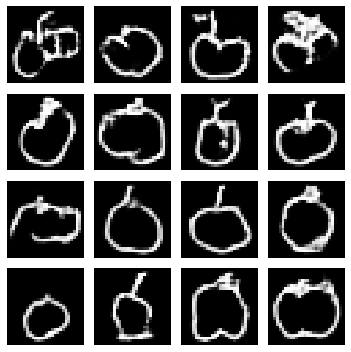

Epoch #759
759: [D loss: 0.444112, acc: 0.000005]  [A loss: 1.949919, acc: 0.127357]


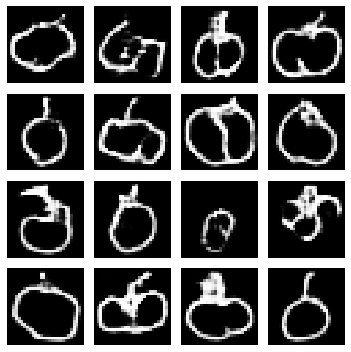

Epoch #779
779: [D loss: 0.444154, acc: 0.000005]  [A loss: 1.948739, acc: 0.127236]


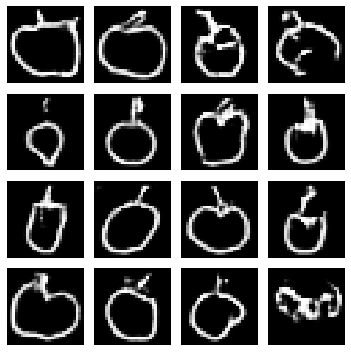

Epoch #799
799: [D loss: 0.444167, acc: 0.000005]  [A loss: 1.948828, acc: 0.126760]


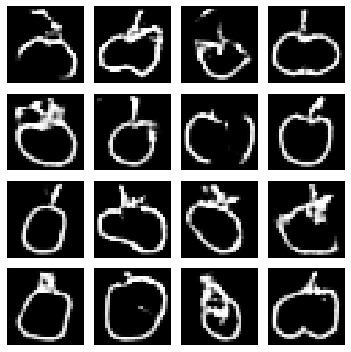

Epoch #819
819: [D loss: 0.444094, acc: 0.000005]  [A loss: 1.950219, acc: 0.126173]


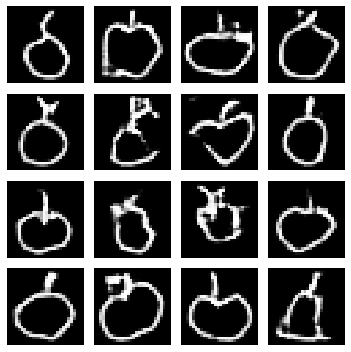

Epoch #839
839: [D loss: 0.443836, acc: 0.000005]  [A loss: 1.952270, acc: 0.125531]


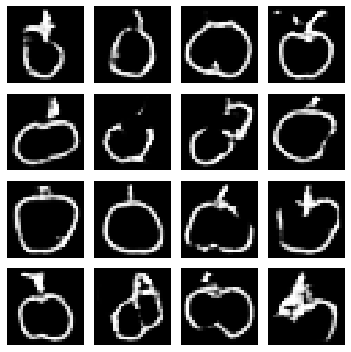

Epoch #859
859: [D loss: 0.443992, acc: 0.000005]  [A loss: 1.950823, acc: 0.125737]


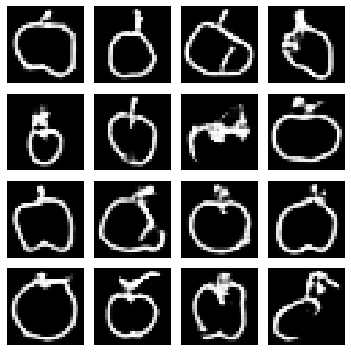

Epoch #879
879: [D loss: 0.443846, acc: 0.000004]  [A loss: 1.951974, acc: 0.125364]


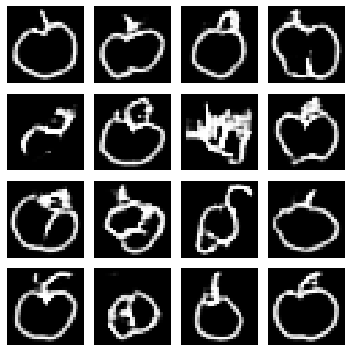

Epoch #899
899: [D loss: 0.443452, acc: 0.000004]  [A loss: 1.953978, acc: 0.124965]


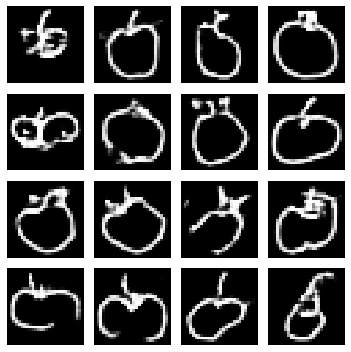

Epoch #919
919: [D loss: 0.442913, acc: 0.000004]  [A loss: 1.957002, acc: 0.124286]


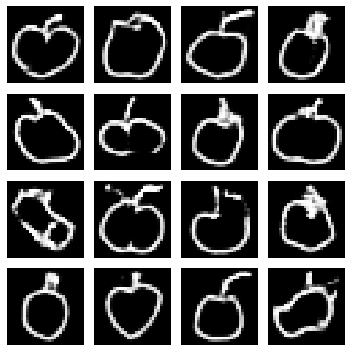

Epoch #939
939: [D loss: 0.442710, acc: 0.000004]  [A loss: 1.958934, acc: 0.123918]


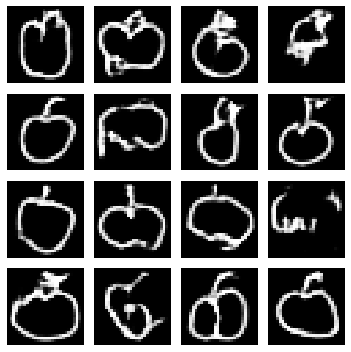

Epoch #959
959: [D loss: 0.442424, acc: 0.000004]  [A loss: 1.961374, acc: 0.123346]


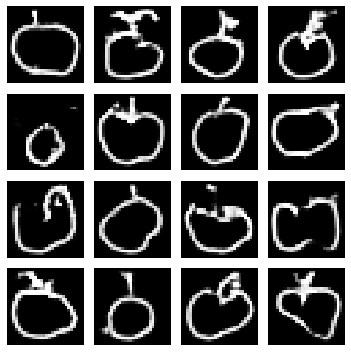

Epoch #979
979: [D loss: 0.442184, acc: 0.000004]  [A loss: 1.962638, acc: 0.122997]


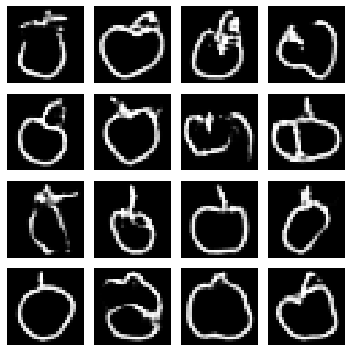

Epoch #999
999: [D loss: 0.441688, acc: 0.000004]  [A loss: 1.965632, acc: 0.122443]


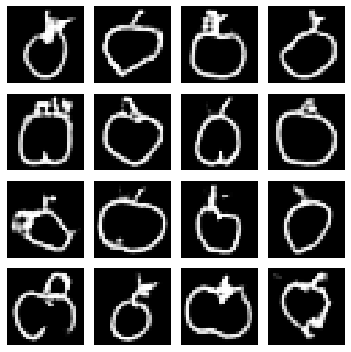

Epoch #1019
1019: [D loss: 0.441108, acc: 0.000004]  [A loss: 1.969167, acc: 0.122102]


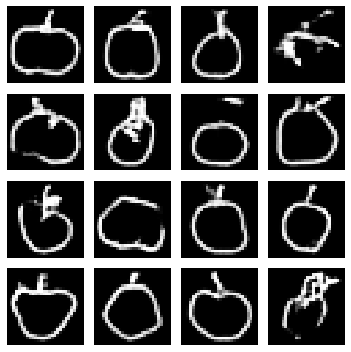

Epoch #1039
1039: [D loss: 0.440742, acc: 0.000004]  [A loss: 1.970588, acc: 0.121902]


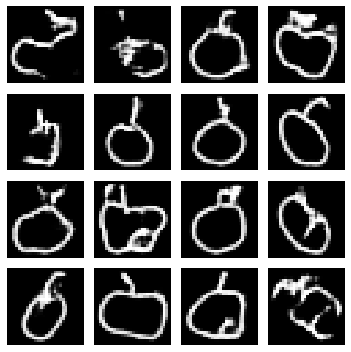

Epoch #1059
1059: [D loss: 0.440417, acc: 0.000004]  [A loss: 1.975334, acc: 0.121112]


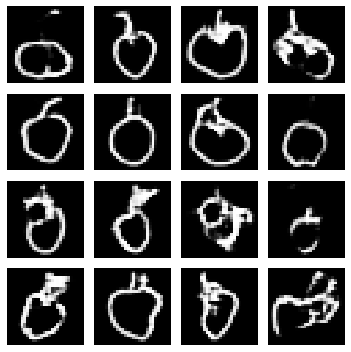

Epoch #1079
1079: [D loss: 0.440006, acc: 0.000004]  [A loss: 1.979015, acc: 0.120395]


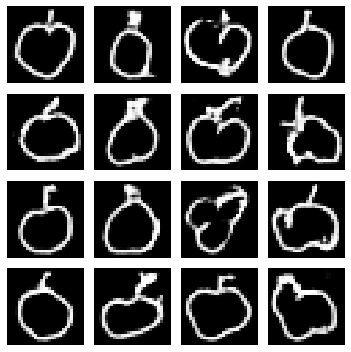

Epoch #1099
1099: [D loss: 0.439715, acc: 0.000004]  [A loss: 1.981133, acc: 0.120067]


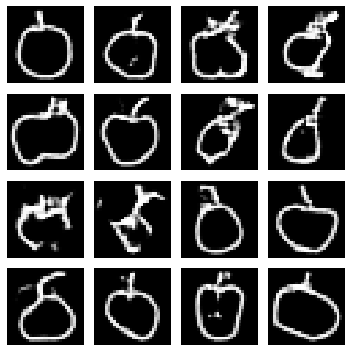

Epoch #1119
1119: [D loss: 0.439245, acc: 0.000003]  [A loss: 1.983387, acc: 0.119841]


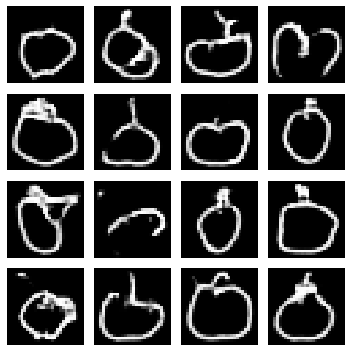

Epoch #1139
1139: [D loss: 0.438940, acc: 0.000003]  [A loss: 1.986014, acc: 0.119273]


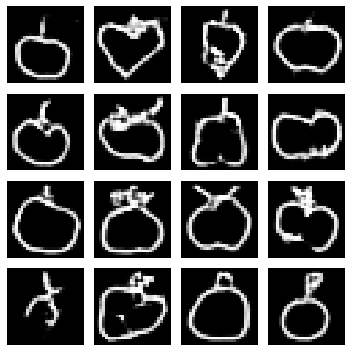

Epoch #1159
1159: [D loss: 0.438630, acc: 0.000003]  [A loss: 1.987941, acc: 0.118832]


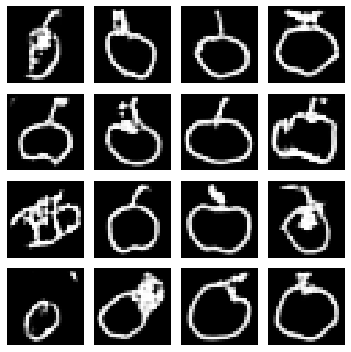

Epoch #1179
1179: [D loss: 0.437998, acc: 0.000003]  [A loss: 1.991151, acc: 0.118294]


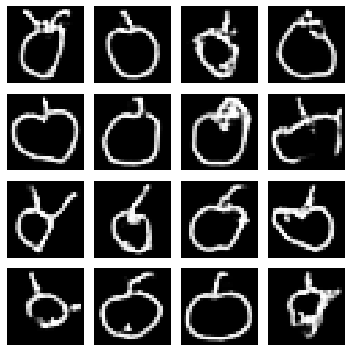

Epoch #1199
1199: [D loss: 0.437779, acc: 0.000003]  [A loss: 1.992542, acc: 0.117898]


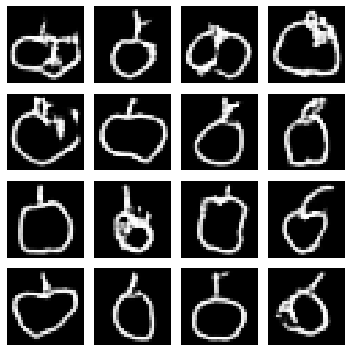

Epoch #1219
1219: [D loss: 0.437375, acc: 0.000003]  [A loss: 1.994864, acc: 0.117354]


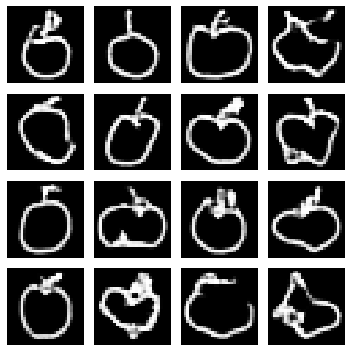

Epoch #1239
1239: [D loss: 0.436749, acc: 0.000003]  [A loss: 1.998632, acc: 0.116916]


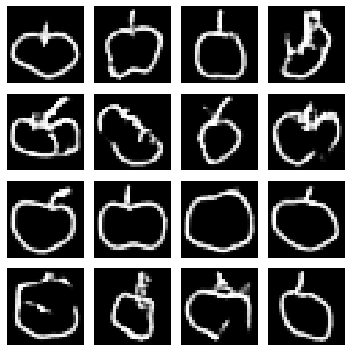

Epoch #1259
1259: [D loss: 0.436290, acc: 0.000003]  [A loss: 2.001310, acc: 0.116430]


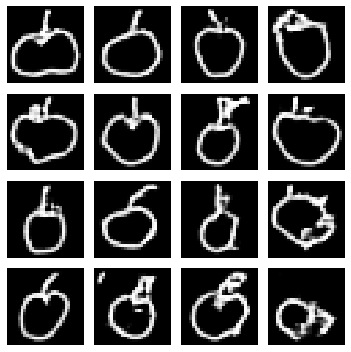

Epoch #1279
1279: [D loss: 0.436104, acc: 0.000003]  [A loss: 2.002270, acc: 0.116204]


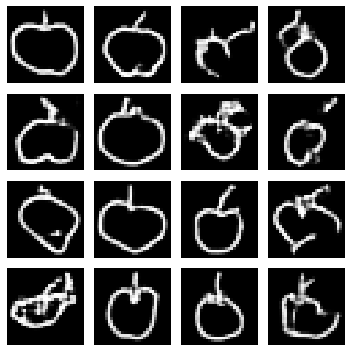

Epoch #1299
1299: [D loss: 0.435390, acc: 0.000003]  [A loss: 2.006863, acc: 0.115546]


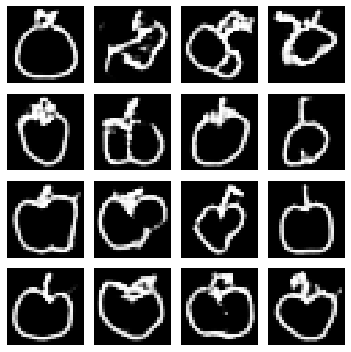

Epoch #1319
1319: [D loss: 0.434954, acc: 0.000003]  [A loss: 2.009499, acc: 0.115221]


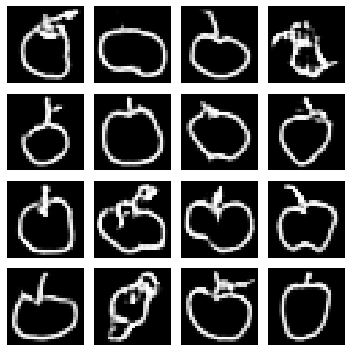

Epoch #1339
1339: [D loss: 0.434630, acc: 0.000003]  [A loss: 2.011898, acc: 0.114906]


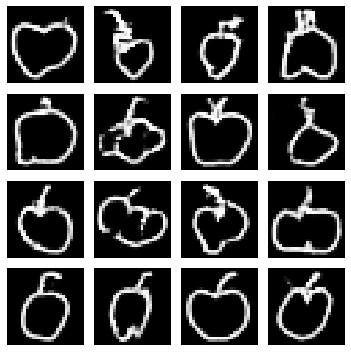

Epoch #1359
1359: [D loss: 0.434005, acc: 0.000003]  [A loss: 2.015328, acc: 0.114405]


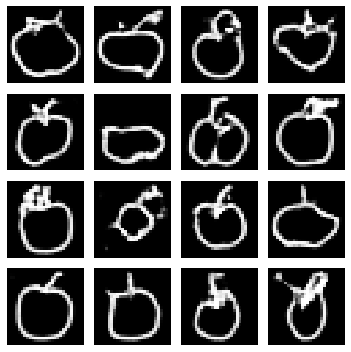

Epoch #1379
1379: [D loss: 0.433466, acc: 0.000003]  [A loss: 2.018507, acc: 0.114106]


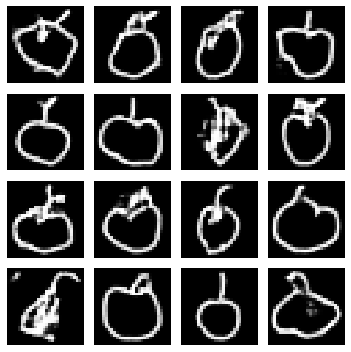

Epoch #1399
1399: [D loss: 0.432779, acc: 0.000003]  [A loss: 2.021929, acc: 0.113882]


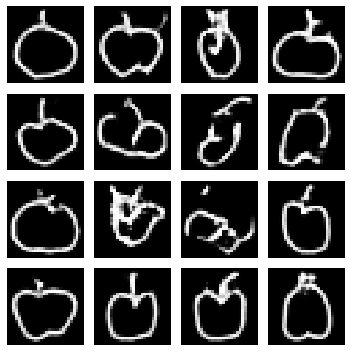

Epoch #1419
1419: [D loss: 0.432141, acc: 0.000003]  [A loss: 2.025753, acc: 0.113345]


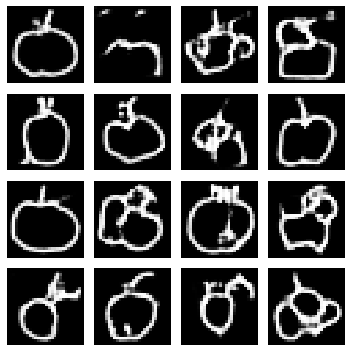

Epoch #1439
1439: [D loss: 0.431828, acc: 0.000003]  [A loss: 2.027148, acc: 0.113317]


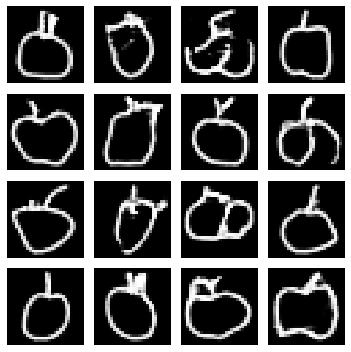

Epoch #1459
1459: [D loss: 0.431458, acc: 0.000003]  [A loss: 2.028875, acc: 0.113145]


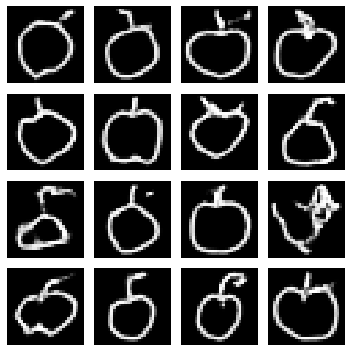

Epoch #1479
1479: [D loss: 0.430974, acc: 0.000003]  [A loss: 2.032702, acc: 0.112814]


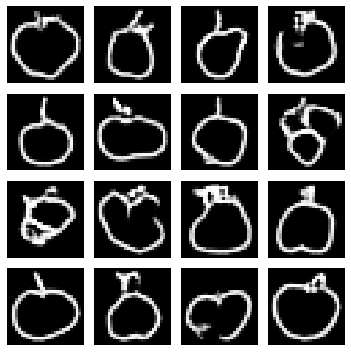

Epoch #1499
1499: [D loss: 0.430673, acc: 0.000003]  [A loss: 2.035252, acc: 0.112413]


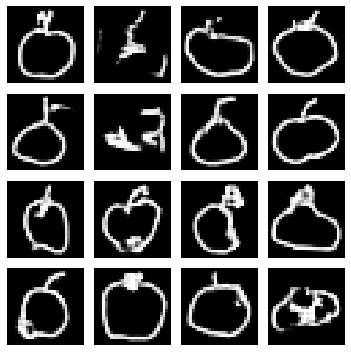

Epoch #1519
1519: [D loss: 0.430190, acc: 0.000003]  [A loss: 2.037689, acc: 0.112065]


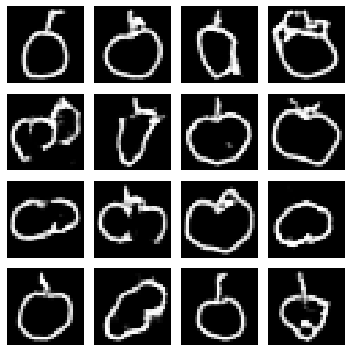

Epoch #1539
1539: [D loss: 0.429834, acc: 0.000003]  [A loss: 2.039754, acc: 0.111878]


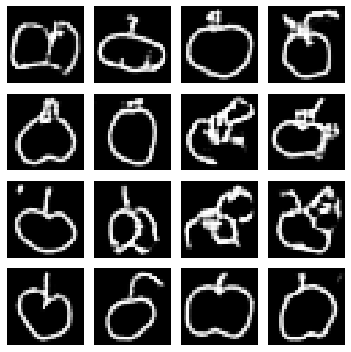

Epoch #1559
1559: [D loss: 0.429601, acc: 0.000003]  [A loss: 2.041111, acc: 0.111540]


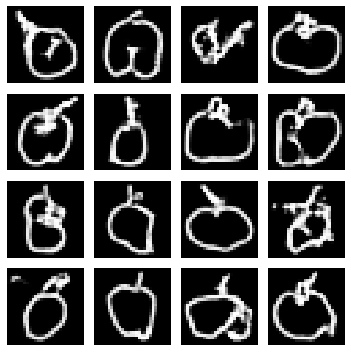

Epoch #1579
1579: [D loss: 0.429198, acc: 0.000002]  [A loss: 2.043390, acc: 0.111290]


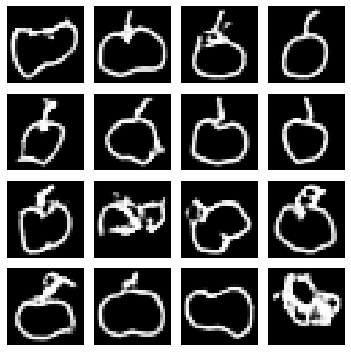

Epoch #1599
1599: [D loss: 0.428707, acc: 0.000002]  [A loss: 2.047360, acc: 0.111070]


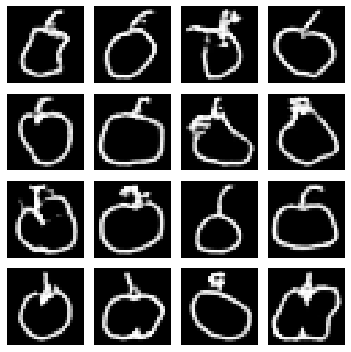

Epoch #1619
1619: [D loss: 0.428096, acc: 0.000002]  [A loss: 2.050667, acc: 0.110519]


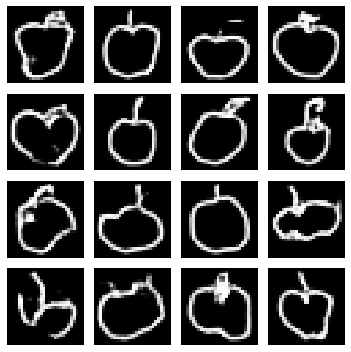

Epoch #1639
1639: [D loss: 0.427848, acc: 0.000002]  [A loss: 2.052671, acc: 0.110500]


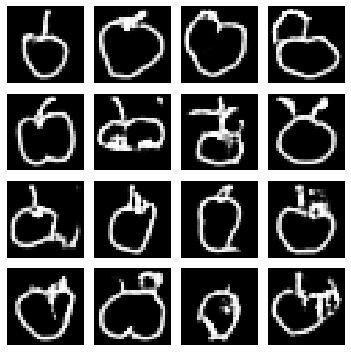

Epoch #1659
1659: [D loss: 0.427509, acc: 0.000002]  [A loss: 2.054059, acc: 0.110237]


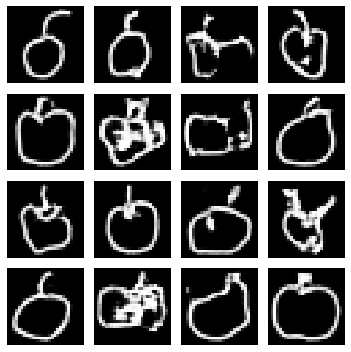

Epoch #1679
1679: [D loss: 0.427040, acc: 0.000002]  [A loss: 2.056742, acc: 0.109957]


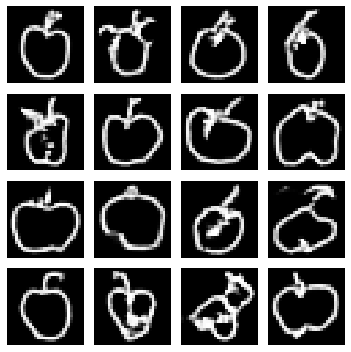

Epoch #1699
1699: [D loss: 0.426750, acc: 0.000002]  [A loss: 2.058570, acc: 0.109757]


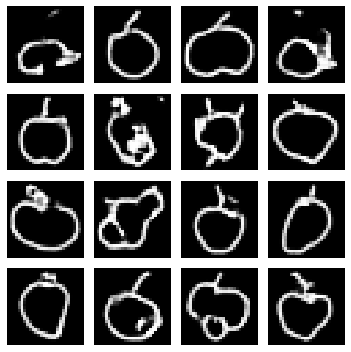

Epoch #1719
1719: [D loss: 0.426224, acc: 0.000002]  [A loss: 2.061142, acc: 0.109398]


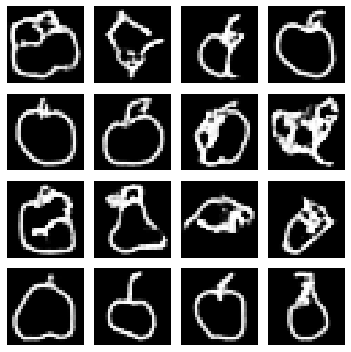

Epoch #1739
1739: [D loss: 0.425839, acc: 0.000002]  [A loss: 2.063755, acc: 0.109168]


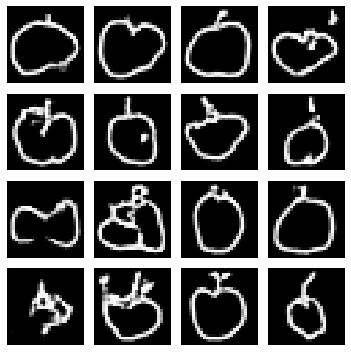

Epoch #1759
1759: [D loss: 0.425467, acc: 0.000002]  [A loss: 2.066111, acc: 0.109109]


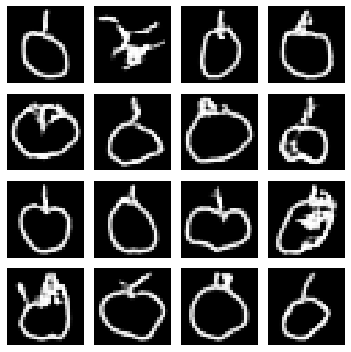

Epoch #1779
1779: [D loss: 0.425177, acc: 0.000002]  [A loss: 2.068364, acc: 0.108914]


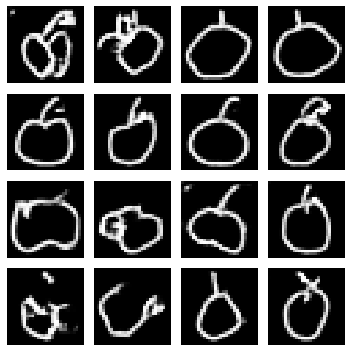

Epoch #1799
1799: [D loss: 0.424740, acc: 0.000002]  [A loss: 2.070178, acc: 0.108667]


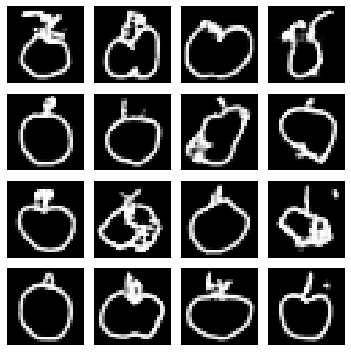

Epoch #1819
1819: [D loss: 0.424416, acc: 0.000002]  [A loss: 2.071845, acc: 0.108426]


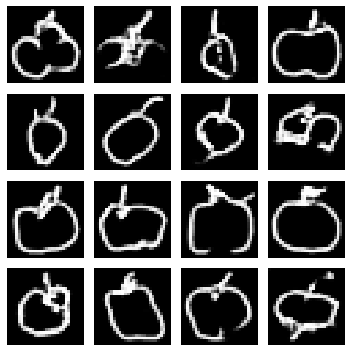

Epoch #1839
1839: [D loss: 0.424071, acc: 0.000002]  [A loss: 2.072649, acc: 0.108372]


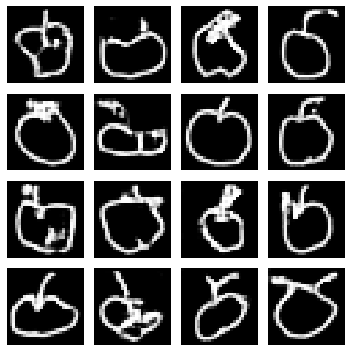

Epoch #1859
1859: [D loss: 0.423764, acc: 0.000002]  [A loss: 2.074588, acc: 0.108081]


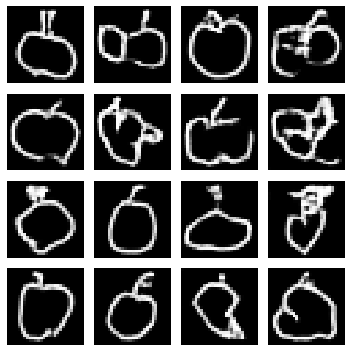

Epoch #1879
1879: [D loss: 0.423515, acc: 0.000002]  [A loss: 2.075787, acc: 0.108011]


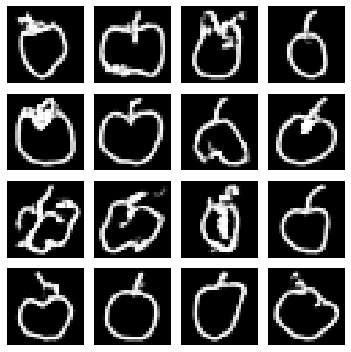

Epoch #1899
1899: [D loss: 0.423280, acc: 0.000002]  [A loss: 2.078190, acc: 0.107684]


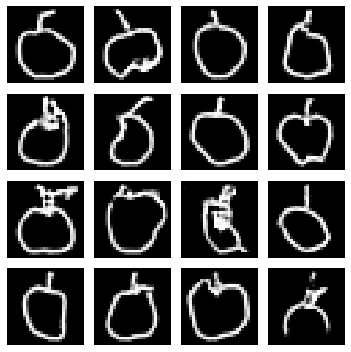

Epoch #1919
1919: [D loss: 0.422987, acc: 0.000002]  [A loss: 2.080521, acc: 0.107360]


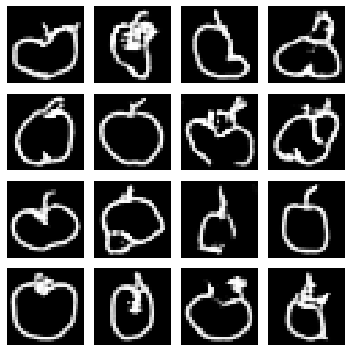

Epoch #1939
1939: [D loss: 0.422647, acc: 0.000002]  [A loss: 2.082558, acc: 0.107320]


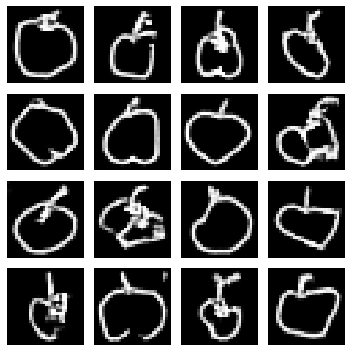

Epoch #1959
1959: [D loss: 0.422283, acc: 0.000002]  [A loss: 2.084638, acc: 0.107042]


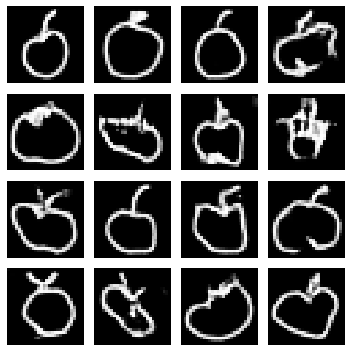

Epoch #1979
1979: [D loss: 0.422018, acc: 0.000002]  [A loss: 2.085588, acc: 0.106991]


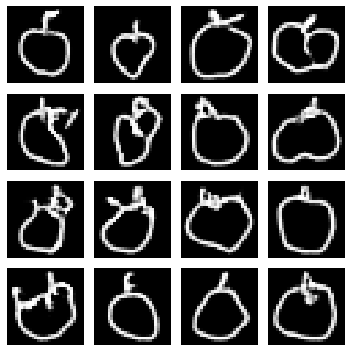

Epoch #1999
1999: [D loss: 0.421912, acc: 0.000002]  [A loss: 2.086094, acc: 0.106850]


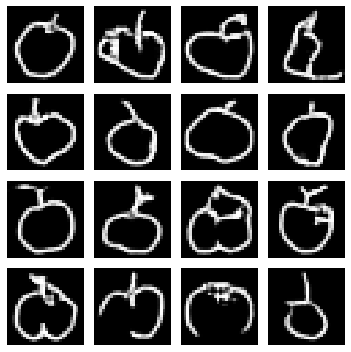

In [25]:
a_metrics_complete, d_metrics_complete = train()

Text(0, 0.5, 'Loss')

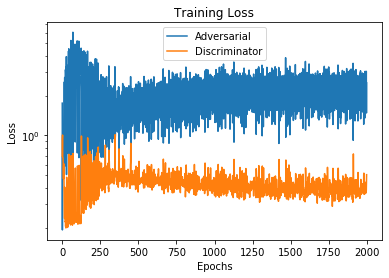

In [26]:
ax = pd.DataFrame(
    {
        'Adversarial': [metric[0] for metric in a_metrics_complete],
        'Discriminator': [metric[0] for metric in d_metrics_complete],
    }
).plot(title='Training Loss', logy=True)
ax.set_xlabel("Epochs")
ax.set_ylabel("Loss")

Text(0, 0.5, 'Accuracy')

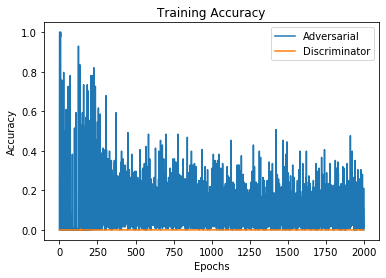

In [27]:
ax = pd.DataFrame(
    {
        'Adversarial': [metric[1] for metric in a_metrics_complete],
        'Discriminator': [metric[1] for metric in d_metrics_complete],
    }
).plot(title='Training Accuracy')
ax.set_xlabel("Epochs")
ax.set_ylabel("Accuracy")